In [1]:
import pandas as pd
#import numpy as np
import binance
import ccxt

from pprint import pprint





#  CCXT and Binance REST 

In [3]:
id = 'binance'; symbol = 'EOS/BTC'; start = '30 minutes ago UTC'; end = 'Now'; timeframe = '1h'; limit=100
key = 'foo'; secret = 'bar'; #when using the private api connection, you need real keys and secrets for your account 

#these lines get the latest candlesticks by using ccxt
exchange = getattr(ccxt, id)({})
klines = exchange.fetch_ohlcv(symbol, timeframe, limit=limit)

#while these lines get the latest candlesticks by using directly binances REST api
#clientpub = Client(key, secret, {"verify": True, "timeout": 3})
#klines = clientpub.get_historical_klines(symbol, timeframe, start, end)

pprint(klines)



[[1539788400000, 0.0008244, 0.0008254, 0.0008238, 0.0008245, 168879.01],
 [1539792000000, 0.0008244, 0.0008245, 0.0008236, 0.0008245, 155741.48],
 [1539795600000, 0.0008244, 0.0008245, 0.0008235, 0.0008242, 142062.33],
 [1539799200000, 0.0008244, 0.0008245, 0.0008228, 0.0008242, 167408.8],
 [1539802800000, 0.0008243, 0.0008245, 0.0008224, 0.0008245, 190223.26],
 [1539806400000, 0.0008245, 0.0008245, 0.0008213, 0.0008235, 129826.99],
 [1539810000000, 0.0008234, 0.00083, 0.0008228, 0.0008297, 226729.83],
 [1539813600000, 0.0008296, 0.00083, 0.0008265, 0.0008277, 144084.17],
 [1539817200000, 0.0008277, 0.0008288, 0.0008254, 0.0008265, 152448.43],
 [1539820800000, 0.0008267, 0.0008272, 0.0008246, 0.0008268, 126740.18],
 [1539824400000, 0.0008259, 0.0008275, 0.0008237, 0.000825, 139404.46],
 [1539828000000, 0.0008251, 0.0008274, 0.0008232, 0.0008271, 147582.83],
 [1539831600000, 0.0008268, 0.000831, 0.000826, 0.0008279, 189508.73],
 [1539835200000, 0.0008279, 0.0008282, 0.0008261, 0.000827,

to understand the output, have a look at: https://github.com/binance-exchange/binance-official-api-docs/blob/master/rest-api.md
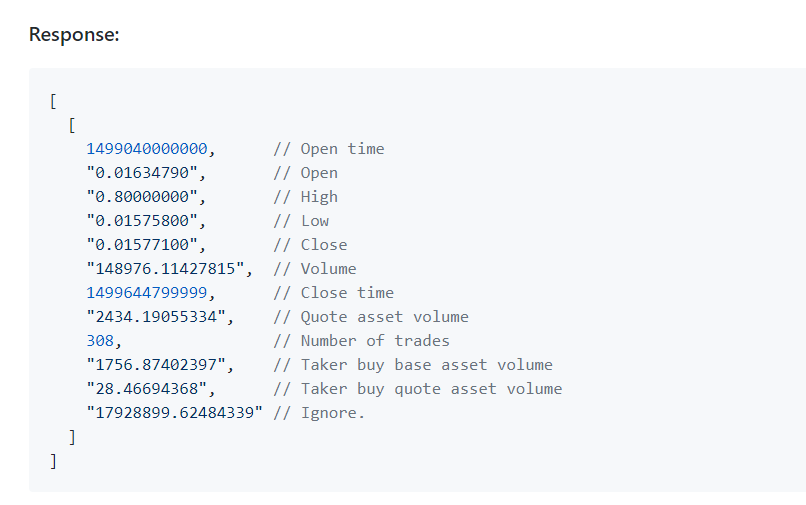

In [4]:
#I prefer converting the candles into the feature rich pandas dataframes, which makes its easy to do math and TA.

from collections import deque

candles = deque(maxlen=len(klines))

for k in klines:
    parse = {}
    parse['Opentime'] = float(k[0])/1000
    parse['Open'] = float(k[1])
    parse['High'] = float(k[2])
    parse['Low'] = float(k[3])
    parse['Close'] = float(k[4])
    parse['Volume'] = float(k[5])
    candles.append(parse)

ohlcv = pd.DataFrame(list(candles)) 
print(ohlcv)

       Close      High       Low      Open      Opentime     Volume
0   0.000825  0.000825  0.000824  0.000824  1.539788e+09  168879.01
1   0.000825  0.000825  0.000824  0.000824  1.539792e+09  155741.48
2   0.000824  0.000825  0.000824  0.000824  1.539796e+09  142062.33
3   0.000824  0.000825  0.000823  0.000824  1.539799e+09  167408.80
4   0.000825  0.000825  0.000822  0.000824  1.539803e+09  190223.26
5   0.000824  0.000825  0.000821  0.000825  1.539806e+09  129826.99
6   0.000830  0.000830  0.000823  0.000823  1.539810e+09  226729.83
7   0.000828  0.000830  0.000826  0.000830  1.539814e+09  144084.17
8   0.000826  0.000829  0.000825  0.000828  1.539817e+09  152448.43
9   0.000827  0.000827  0.000825  0.000827  1.539821e+09  126740.18
10  0.000825  0.000828  0.000824  0.000826  1.539824e+09  139404.46
11  0.000827  0.000827  0.000823  0.000825  1.539828e+09  147582.83
12  0.000828  0.000831  0.000826  0.000827  1.539832e+09  189508.73
13  0.000827  0.000828  0.000826  0.000828  1.53

# Let's plot it

<IPython.core.display.Javascript object>


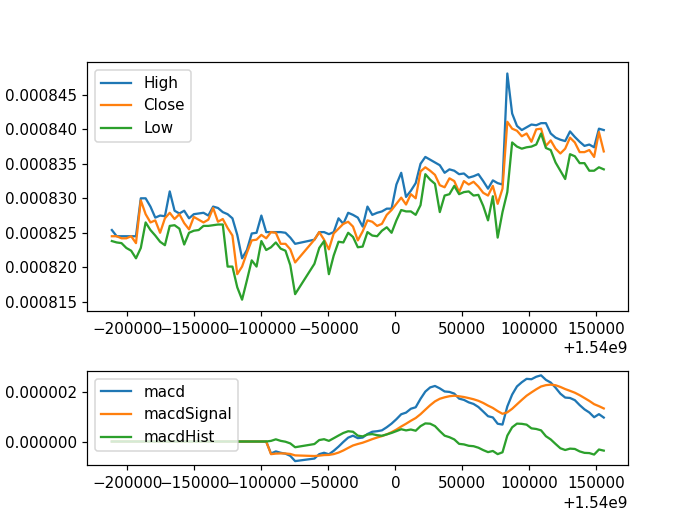

In [8]:
#this is useless for the bot itself, but its helpful for us weak humans to see the TA too.

%matplotlib notebook
import matplotlib.pyplot as plt
import talib as ta
#import tulipy as ti #some TA is calculated wrong in talib, e.g. the stochastic indicators, so then rather use tulipy
#from mpl_finance import candlestick_ohlc


ohlcv['macd'], ohlcv['macdSignal'], ohlcv['macdHist'] = ta.MACD(ohlcv.Close.values)
ohlcv.fillna(0,inplace=True)

fig = plt.figure()
ax1 = plt.subplot2grid((8,1), (0,0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((8,1), (6,0), rowspan=2, colspan=1)#,sharex=ax1)

ax1.plot(ohlcv['Opentime'],ohlcv['High'],label='High')
ax1.plot(ohlcv['Opentime'],ohlcv['Close'],label='Close')
ax1.plot(ohlcv['Opentime'],ohlcv['Low'],label='Low')
ax1.legend(loc='upper left')

#instead of the ax1 lines, we can plot it as candlesticks with the line below, 
#but this requires converting the timestamps, so it doesn't work here :P
#candlestick_ohlc(ax1, ohlcv.values, width=1.0, colorup='#77d879', colordown='#db3f3f')

ax2.plot(ohlcv['Opentime'],ohlcv['macd'],label='macd')
ax2.plot(ohlcv['Opentime'],ohlcv['macdSignal'],label='macdSignal')
ax2.plot(ohlcv['Opentime'],ohlcv['macdHist'],label='macdHist')
ax2.legend(loc='upper left')


In [22]:
#we can also use the Rest queries for gathering data for a large amount of markets 
import time

timeframe = '1h'; limit=100
exchanges = ['binanace','bitmex','bittrex','bitfinex','cryptopia'] #and potentially any more

#these two loops goes through every market in every exchange listed in 'exchanges'
for ex in exchanges: 
    exchange = getattr(ccxt, ex)({})

    for symbol in exchange.markets:
        print(symbol)
        candles = exchange.fetch_ohlcv(symbol, timeframe, limit=10)
        pprint (candles)

        #have to wait a short while to stay within the api quiery limit
        time.sleep (exchange.rateLimit / 1000) # time.sleep wants seconds

ETH/BTC
[[1539766800000, 0.031789, 0.031808, 0.031754, 0.031784, 9862.083],
 [1539770400000, 0.031771, 0.03179, 0.031636, 0.031712, 8299.794],
 [1539774000000, 0.031709, 0.03172, 0.031469, 0.031598, 17228.759],
 [1539777600000, 0.031599, 0.031639, 0.031561, 0.031628, 7043.58],
 [1539781200000, 0.031628, 0.031652, 0.031551, 0.031595, 9871.712],
 [1539784800000, 0.031594, 0.031792, 0.0314, 0.031733, 14130.487],
 [1539788400000, 0.031721, 0.031759, 0.031661, 0.031693, 7184.226],
 [1539792000000, 0.031685, 0.03173, 0.03165, 0.03168, 8361.657],
 [1539795600000, 0.031687, 0.031688, 0.03161, 0.031642, 6674.657],
 [1539799200000, 0.031642, 0.03165, 0.03162, 0.03163, 817.817]]
LTC/BTC
[[1539766800000, 0.00816, 0.00818, 0.008154, 0.008172, 7825.88],
 [1539770400000, 0.008172, 0.008186, 0.008156, 0.00816, 6913.25],
 [1539774000000, 0.008157, 0.008164, 0.00813, 0.008146, 7787.18],
 [1539777600000, 0.008143, 0.008156, 0.008125, 0.008155, 6825.09],
 [1539781200000, 0.008154, 0.008169, 0.008143, 0.00

HSR/BTC
[[1533664800000, 0.00073, 0.000734, 0.000725, 0.00073, 607.67],
 [1533668400000, 0.000729, 0.00073, 0.000722, 0.000726, 1884.13],
 [1533672000000, 0.000723, 0.000728, 0.000716, 0.000718, 6589.44],
 [1533675600000, 0.000718, 0.00073, 0.000713, 0.000716, 6689.96],
 [1533679200000, 0.000716, 0.000722, 0.00071, 0.00071, 1937.59],
 [1533682800000, 0.000712, 0.000712, 0.000704, 0.000706, 1590.56],
 [1533686400000, 0.000706, 0.000711, 0.000696, 0.000703, 11870.85],
 [1533690000000, 0.000701, 0.000727, 0.000701, 0.00071, 3843.57],
 [1533693600000, 0.000711, 0.000718, 0.000707, 0.000716, 2456.99],
 [1533697200000, 0.000717, 0.000718, 0.000709, 0.000714, 935.45]]
OAX/ETH
[[1539766800000, 0.0011577, 0.001174, 0.0011513, 0.0011642, 7261.0],
 [1539770400000, 0.0011639, 0.001188, 0.0011573, 0.0011587, 8126.0],
 [1539774000000, 0.0011662, 0.0012018, 0.0011614, 0.0011869, 20585.0],
 [1539777600000, 0.0011873, 0.0012031, 0.0011776, 0.0012004, 26591.0],
 [1539781200000, 0.0011833, 0.001208, 0.00

KeyboardInterrupt: 

# Websockets

In [2]:
#this exact websocket code is only for binanace, many other exchanges should also have something similar
from binance.client import Client
from binance.websockets import BinanceSocketManager

def process_message(msg): #this function is run every time we get an message (input into "msg") through the websocket
    print(msg)
    
interval = '1m'; symbol = 'ETHBTC'
clientpub = Client('','', {"verify": True, "timeout": 3})
bm = BinanceSocketManager(clientpub)  
#the lines above configures the websocket, and the one below starts it
conn_key = bm.start_kline_socket(symbol, process_message)

In [3]:
#websockets run until they are stopped (binances websockets also stop after 24 hrs) 
bm.stop_socket(conn_key)
bm.close()

In [10]:
'''
What is more usefull is multiplexing multiple websockets into one connection. 
Here the data stream is fed into process_m_message, which splits into parseCandles or parseOrderBook, 
depending on which data stream the message comes from. So put the technical analysis of your strategy into these functions. 

This makes it very to trade multiple markets or exchanges at the same time!
'''

def process_m_message(msg):
    if msg['stream'] == symbol.lower()+'@depth'+str(depth):
        parseOrderBook(msg)
    elif msg['stream'] == symbol.lower()+'@kline_'+interval:
        parseKlines(msg)
    else:
        print('no message!?!'+str(msg))

def parseCandles(smsg):
    pprint(smsg)
    print('I got lots of candles!')
    
def parseOrderBook(smsg):  
    pprint(smsg)
    print('I got a yummy orderbook')
    
depth = 20; interval = '1m'; symbol = 'LUNBTC'
    
clientpub = Client('','', {"verify": True, "timeout": 3})
bm = BinanceSocketManager(clientpub)
conn_key = bm.start_multiplex_socket([symbol.lower()+'@depth'+str(depth), symbol.lower()+'@kline_'+interval], process_m_message)
bm.start()




I got a yummy orderbook
I got a yummy orderbook
I got lots of candles!
I got a yummy orderbook
I got a yummy orderbook
I got a yummy orderbook
I got lots of candles!
I got a yummy orderbook
I got a yummy orderbook
I got a yummy orderbook
I got a yummy orderbook
I got a yummy orderbook
I got lots of candles!
I got a yummy orderbook
I got a yummy orderbook
I got a yummy orderbook
I got a yummy orderbook
I got a yummy orderbook
I got a yummy orderbook
I got a yummy orderbook
I got lots of candles!
I got a yummy orderbook
I got a yummy orderbook
I got a yummy orderbook
I got a yummy orderbook
I got lots of candles!
I got a yummy orderbook
I got a yummy orderbook
I got lots of candles!
I got a yummy orderbook
I got a yummy orderbook
I got a yummy orderbook
I got a yummy orderbook
I got a yummy orderbook
I got a yummy orderbook
I got a yummy orderbook
I got a yummy orderbook
I got a yummy orderbook
I got a yummy orderbook
I got a yummy orderbook
I got a yummy orderbook
I got a yummy orderboo

In [11]:
bm.stop_socket(conn_key)
bm.close()

I got a yummy orderbook
